In [77]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocessing
from sklearn.cluster import DBSCAN
from sklearn import linear_model
import scipy.interpolate as ip
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import scipy as sp
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations

In [2]:
data = pd.read_csv('Indicators.csv')
data.shape

(5656458, 6)

In [3]:
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [4]:
def corr(data, column):
    data=data[(data['Year'] >= 2000) & (data['Year'] < 2014) ]
    for i in data.columns:
        if data.isna().sum()[i]/len(data) >=0.8:
            data=data.drop(columns=[i])

    rel_columns= []
    rel_columns_7=[]
    unique_name = data['IndicatorName'].unique()
    for i in range(len(unique_name)):
        #print(unique_name[i])
        indicator = data[data['IndicatorName'] == unique_name[i]]
        indicator.rename(columns={"Value": unique_name[i]}, inplace = True)
        indicator=indicator.drop(columns=['IndicatorCode', 'IndicatorName', 'CountryName'])
        merged = pd.merge(target, indicator)
        corr=merged.corr()
        if corr["Value"][unique_name[i]] > 0.8 or corr["Value"][unique_name[i]] < -0.8:
            rel_columns.append(unique_name[i])
        if corr['Value'][unique_name[i]] > 0.7 or corr["Value"][unique_name[i]] < -0.7:
            rel_columns_7.append(unique_name[i])
    return rel_columns, rel_columns_7

In [5]:
#일단 이렇게 되는데, 나중에 주석 풀고 하는게 나을듯
#rel_columns_8,rel_columns_7=corr(data2000)

In [6]:
# 여기서부터 관련도 높은 feature 뽑는 것
target_id = 'Adolescent fertility rate (births per 1,000 women ages 15-19)';

target = data[data['IndicatorName']==target_id]

In [96]:
feature=[
    
    'Adjusted net national income (current US$)','Age dependency ratio, young (% of working-age population)',
    'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)',
    'Birth rate, crude (per 1,000 people)','Births attended by skilled health staff (% of total)'
    ,'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'CPIA gender equality rating (1=low to 6=high)','GDP (constant LCU)' ,'Net enrolment rate, secondary, both sexes (%)',
 'Net enrolment rate, secondary, female (%)', 'Net enrolment rate, secondary, male (%)','Population, ages 15-64',   
'Life expectancy at birth' ,'female (years),Life expectancy at birth, male (years)',
'Life expectancy at birth, total (years)',
'Prevalence of anemia among children (% of children under 5)',
'Mortality rate, adult, female (per 1,000 female adults)',
'Population, ages 0-14 (% of total)',
'Survival to age 65, female (% of cohort)',
'Improved water source (% of population with access)',
'Improved water source, rural (% of rural population with access)',
'Lifetime risk of maternal death (%)'
]

In [83]:
def selection_feature(feature,num):
    return list(combinations(feature,num))

In [91]:
# 해당하는 indicator해서 그 데이터 프레임 사용하기 편하게 바꿔주는거 
def transformDf(d, ind, tf):
    data2000=d[(d['Year'] >= 2006) & (d['Year'] < 2014) ]
    
    
    if tf==True:
        
        col8 = data2000[(data2000['IndicatorName'].isin(ind))]
        col8=col8.reset_index(drop=True)
        
    else:
        col8 = data2000[data2000['IndicatorName']==ind]
        col8=col8.reset_index(drop=True)
    
    name_list = list()

    for i in col8.index:
        name_list.append( col8.loc[i,'CountryName'] + "_" + str(col8.loc[i,'Year']))
    col8["name"] = name_list

    col8=col8.pivot_table(values="Value",index="name",columns=["IndicatorName"] )
    
    return col8
    
    

In [10]:

def make_grade(merged, k):
    min_value = min(merged[target_id])
    max_value = max(merged[target_id])
    value=(max_value-min_value)/k
    for i in range(k):
        for j in merged.index:
            if merged.loc[j, target_id] >=min_value + value*i and merged.loc[j, target_id] <= min_value + value*(i+1):
                merged.loc[j, 'grade'] = i
    return merged


In [11]:
def preprocessingMissing(df):
    
    #전체 개수랑 null 값이 비슷 하게 나오는 경우에는 그냥 아예 그 컬럼을 안쓰는게 나을 거 가음
    for i in df.columns:
        if df.isna().sum()[i]/len(df) >=0.7:
            df=df.drop(columns=[i])
            
    data_inter=pd.DataFrame(data=df.values,index=range(len(df)))
    data_inter=data_inter.interpolate(method='index' ,limit_direction="both")
    df=pd.DataFrame(data=data_inter.values,index=df.index, columns=df.columns)


    return df
        

In [12]:
# cleansing dataset
def robust(X):
    # cleansing missing data
    X.dropna(axis=0, thresh=1, inplace=True)
    # cleansing outliers
    robust = preprocessing.RobustScaler().fit(X)

    X_robust = robust.transform(X)
    X_robust = pd.DataFrame(X, columns=X.columns, index=list(X.index.values))
    return X_robust

In [13]:
# scaling data (MinMaxScaler)
def minmax(X):
    scaler = preprocessing.MinMaxScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled

In [14]:
# scaling data (MinMaxScaler)
def standard(X):
    scaler = preprocessing.StandardScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled


In [15]:
def fillnaX(X):
    for i in X.columns:
        df[i] = df[i].fillna(df[i].mean())
    return X                     

In [36]:
#K-means parameter

# DBSCAN parameter
eps=[10, 20, 30, 40, 50 ]
min_samples=[ 3, 5, 10, 15, 20, 30, 50, 100 ]
dis_measure = ['euclidean', 'hamming']

# EM parameter


In [113]:
#나중에 dbscan이나 EM 도 한파일에 있어야되서 함수 명 바꿧어
def runKMeans(df, k,max_iter, n_init):
    
    df=make_grade(df,k)
    kmeans=KMeans(n_clusters=k)
    """
    kmeans= KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=max_iter, 
               n_clusters=k, n_init=n_init, n_jobs=1, precompute_distances='auto', 
               random_state=None, tol=0.0001, verbose=0)
    """
    X= df.drop(['grade',target_id], 1)
    #일단은 다 dropna 처리
    y=df['grade']

    kmeans.fit(X)
    predict=kmeans.predict(X)

    #scatter_plot(df, predict)
    
    return predict,calcAccuracy(predict, X,y)

In [17]:

def calcAccuracy(y_pred, x,y):
    '''
    print accuracy of prediction
    '''
    correct=0
    for i in range(len(x)):
        
        #predict_me= np.array(x[i].astype(float))
        #predict_me = predict_me.reshape(-1, len(predict_me))
        #prediction = kmeans.predict(predict_me)
        #여기서는 predict 값을 넘겨서 [i]로 해야돼
        if y_pred[i] == y[i]:
            correct += 1
    print(correct/len(x))


In [18]:
def runDBSCAN(df,eps, min_samples, metric):
    
    df=make_grade(df,min_samples)
    X=df.drop(columns=['grade',target_id])
    y=df['grade']
    
    """
    X=df.drop(columns=[target_id])
    y=df[target_id]
    """
    
    """
    X = robust(X)
    X= fillnaX(X)
    """
    db = DBSCAN(eps = eps, min_samples = min_samples, metric= metric).fit(X) 

    cluster_labels = db.labels_
    n_clusters = len(set(cluster_labels))
    print(cluster_labels)
    df = make_grade(df, n_clusters)
    scatter_plot(df, cluster_labels)
    
    return calcAccuracy(cluster_labels, X,y)

In [19]:
def runGMM(df, k):
    df=make_grade(df,k)

    X = df.drop(columns=[target_id])
    y=df['grade']
    
   
    #X= fillnaX(X)
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X)

    y_cluster_gmm = gmm.predict(X)
    scatter_plot(df, y_cluster_gmm)

    return calcAccuracy(y_cluster_gmm, X, y)

In [75]:
def bestParmDBSCAN(df):
    
    eps=[10, 20, 30, 40, 50 ]
    min_samples=[ 3, 5, 10, 15, 20, 30, 50, 100 ]
    metric = ['euclidean', 'hamming']

    X=df.drop(columns=['grade',target_id])
        
    best_score = 0
    try:
        for i in min_samples:
            df = make_grade(df,i)
            y=df['grade']
            for j in eps:
                for k in metric:
                    print(i, j, k)
                    db = DBSCAN(eps = i, min_samples = j, metric= k).fit(X) 
                    cluster_labels = db.labels_
                    if len(set(cluster_labels)) == 1:
                        print('one')
                    else:
                        score = silhouette_score(df, cluster_labels)
                        print('silhoutte', score)
                        if i==10 and j ==3 and metric == 'euclidean':
                            best_score = score
                            best_eps, best_min, best_metric = i,j,k
                        if score >= best_score:
                            best_score = score
                            best_eps, best_min, best_metric = i,j,k
    # cluster label 종류가 한개일때는 valueError가 나서 무시하게 함
    except ValueError:
        print('one')
    return best_score, best_eps, best_min, best_metric

In [76]:
best_score, best_eps, best_min, best_metric = bestParmDBSCAN(df)
print(best_score, best_eps, best_min, best_metric)

KeyError: "['grade' 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] not found in axis"

In [20]:
def mode(x):
    return sp.stats.mode(x)[0][0]

In [127]:
def scatter_plot(df, predict):
    plt.figure(figsize=(15,5))
    for i in range(len(set(predict))):
        value = []
        for j in range(len(df)):
            if predict[j] == i:
                value.append(df.iloc[j][target_id])
        grade = [i]*len(value)
        sns.scatterplot(value, grade, alpha=0.3)
    plt.show()


In [84]:
def plotCluster(df,predict,model):
    df_plot=df.copy()
    country=list()
    for i in range(len(df)):
        country.append(df.index.array[i].split("_")[0])
    df_plot['country']=country
    
    if model!="origin":
        df_plot['predict']=label
        df_plot.groupby('country').agg(mode)
        title="Clustering of Countries based on"+model
        ti=np.unique(label)
        d=dict(type='choropleth',locations=df_plot.index,locationmode="country names",
               z=df_plot['predict'],text=df_plot.index,colorbar={"title":"cluster","tickmode":"array","tickvals":ti},
               colorscale="Viridis" 
              )
    else:
        df_plot=df_plot.groupby('country').mean()
        d=dict(type='choropleth',locations=df_plot.index,locationmode="country names",
           z=df_plot[target_id],text=df_plot.index,colorbar={"title":"f" ,"tickmode":"array","tickvals":[0,20,40,60,80,100,120,140,160,180,200]},
           colorscale="Viridis"
          )
        title=target_id
    layout = dict(title=title,height=500,
                  geo=dict(showframe = False,
                           projection = {'type':'mercator'}))
    go.Figure(data=[d],layout=layout).show()

In [92]:
df=transformDf(data,feature,True)
df=preprocessingMissing(df)
df


IndicatorName,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)","Age dependency ratio, young (% of working-age population)","Birth rate, crude (per 1,000 people)",CPIA gender equality rating (1=low to 6=high),GDP (constant LCU),Improved water source (% of population with access),"Improved water source, rural (% of rural population with access)","Life expectancy at birth, total (years)",Lifetime risk of maternal death (%),"Mortality rate, adult, female (per 1,000 female adults)","Net enrolment rate, secondary, both sexes (%)","Net enrolment rate, secondary, female (%)","Net enrolment rate, secondary, male (%)","Population, ages 0-14 (% of total)",Prevalence of anemia among children (% of children under 5),"Survival to age 65, female (% of cohort)"
name,,,,,,,,,,,,,,,,,
Afghanistan_2006,6.391802e+09,123.1616,95.189611,43.893,2.0,2.385196e+11,40.8,34.0,57.432561,5.215934,269.281,27.024059,14.483140,39.084930,47.696334,41.9,56.34296
Afghanistan_2007,8.915827e+09,117.3900,95.573791,42.779,2.0,2.712927e+11,42.6,35.6,57.833829,4.768727,264.908,27.024059,14.483140,39.084930,47.786807,42.0,56.98872
Afghanistan_2008,9.156321e+09,111.4708,95.753705,41.560,2.0,2.810901e+11,44.4,37.3,58.225024,4.363613,261.025,30.324249,17.597977,42.551494,47.825228,42.4,57.57401
Afghanistan_2009,1.129889e+10,105.5516,95.562245,40.265,2.0,3.401770e+11,46.2,38.9,58.603683,3.962105,257.142,33.624439,20.712814,46.018058,47.766678,42.8,58.15931
Afghanistan_2010,1.427348e+10,99.6324,94.921630,38.940,2.0,3.688652e+11,48.0,40.5,58.970829,3.543144,253.259,36.924629,23.827651,49.484621,47.589344,43.6,58.74461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2009,8.421641e+09,115.8354,75.051422,36.094,2.5,8.157077e+09,78.0,68.2,47.624659,2.005713,597.303,43.547720,42.035490,45.000445,41.479777,57.5,32.11813
Zimbabwe_2010,8.888351e+09,115.0006,75.172643,36.267,2.5,9.085020e+09,77.9,68.1,49.574659,1.917720,548.219,43.644610,42.680467,44.569070,41.535128,58.4,36.46822
Zimbabwe_2011,9.433701e+09,114.1658,75.011607,36.264,3.0,1.016663e+10,77.7,67.9,51.600366,1.807816,499.136,43.741500,43.325444,44.137696,41.502380,59.0,40.81831


In [93]:
plotCluster(df,"","origin")

In [ ]:
selection=selection_feature(feature,5)
for i in range(len(selection)):
    selection[i]=list(selection[i])
    selection[i].append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
    print('\n',selection[i],'\n')
    df=transformDf(data,selection[i],True)
    df=preprocessingMissing(df)
    print(runKMeans(df, 2,0, 0))
    


 ['Adjusted net national income (current US$)', 'Age dependency ratio, young (% of working-age population)', 'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)', 'Birth rate, crude (per 1,000 people)', 'Births attended by skilled health staff (% of total)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] 

0.858189429618001
(array([0, 0, 0, ..., 0, 0, 0]), None)

 ['Adjusted net national income (current US$)', 'Age dependency ratio, young (% of working-age population)', 'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)', 'Birth rate, crude (per 1,000 people)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] 

0.14173228346456693
(array([1, 1, 1, ..., 1, 1, 1]), None)

 ['Adjusted net national income (current US$)', 'Age dependency ratio,

In [115]:
eps=[10, 20, 30, 40, 50 ]
min_samples=[ 3, 5, 10, 15, 20, 30, 50, 100 ]
dis_measure = ['euclidean', 'hamming']

[-1 -1 -1 ...  2  2  2]


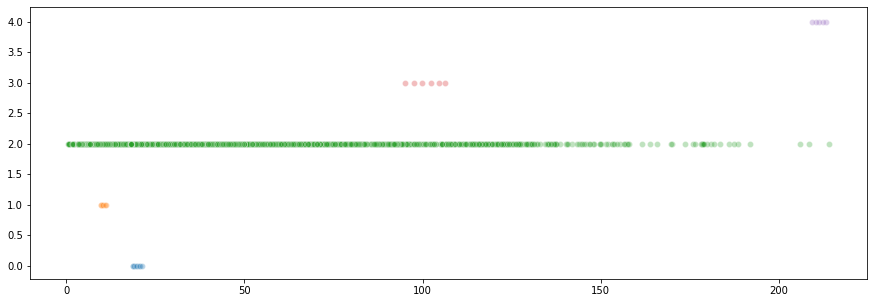

0.1486784140969163


In [126]:
runDBSCAN(df,10,5,'euclidean')

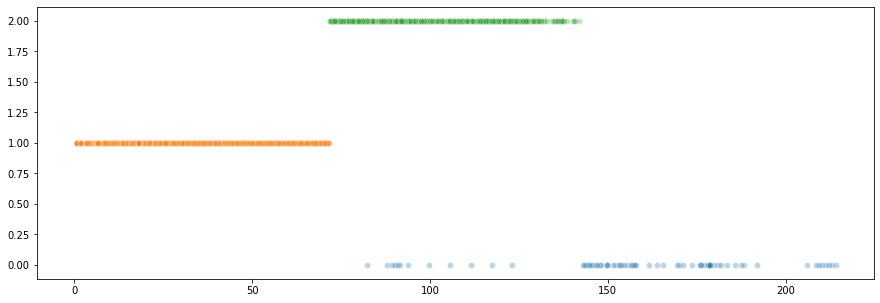

0.0


In [128]:
runGMM(df, 3)

In [117]:
'''
선택지
1. rel_columns_8 or 7
2. 몇개 미만이면 제외할지
3. kmeans parameter
'''

'\n선택지\n1. rel_columns_8 or 7\n2. 몇개 미만이면 제외할지\n3. kmeans parameter\n'

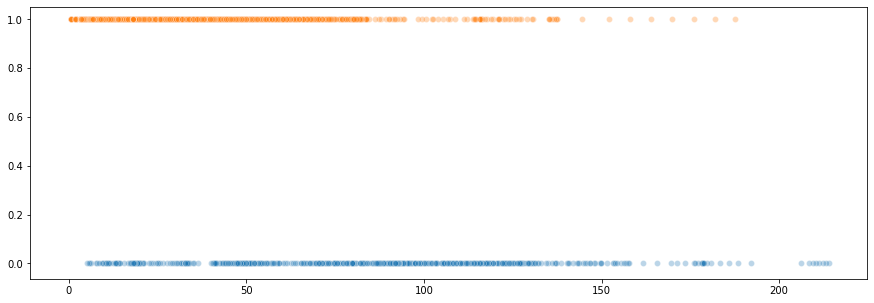

0.2615638766519824


(array([0, 0, 0, ..., 0, 0, 0]), None)

In [125]:
runKMeans(df,2,600,30)

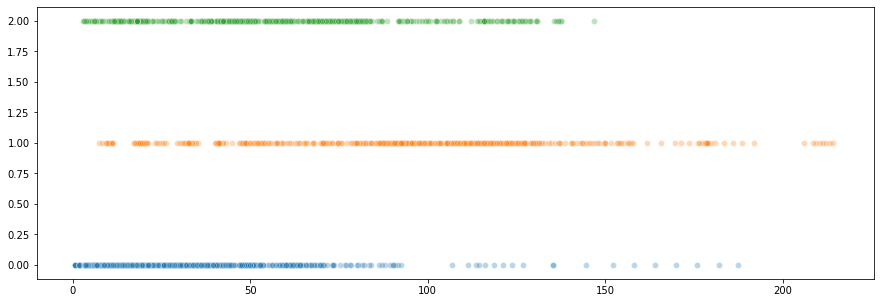

0.5748898678414097


(array([1, 1, 1, ..., 1, 1, 1]), None)

In [124]:
runKMeans(df,3,600,30)

[-1 -1 -1 ...  3  3  3]


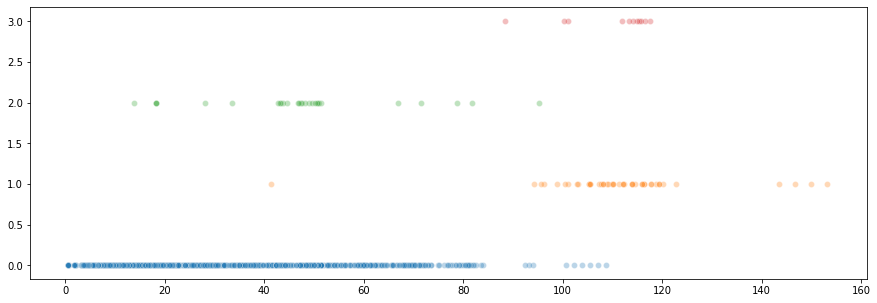

0.355726872246696


In [121]:
runDBSCAN(df,5,10,'euclidean')

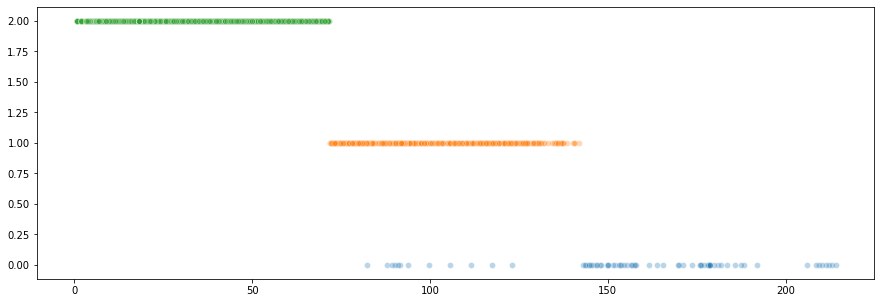

0.23788546255506607


In [122]:
runGMM(df, 3)